In [3]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
import math
import random
import numpy as np
from scipy.optimize import minimize
from qiskit_ibm_provider import IBMProvider
from qiskit.providers.aer.noise import NoiseModel

try:
    from qiskit_ionq import IonQProvider, ErrorMitigation
except (ImportError):
    %pip install qiskit-ionq
    from qiskit_ionq import IonQProvider, ErrorMitigation

f = open("C:\\Users\\fouad\\Documents\\tokens.txt", "r")
next = f.readline()
TOKEN = next[:len(next)-1]
next = f.readline()
TOKEN_IONQ = next[:len(next)-1]

NOISE = True # Use IBM Manila noise model when True, ideal noise when False
IONQ = True # Use IonQ backend when true, use Aer backend when False
COUNTS = True # False means use get_probabilities(), True means use get_counts()

if IONQ:
    provider = IonQProvider(TOKEN_IONQ)
    backend = provider.get_backend('ionq_simulator')
else:
    #IBMProvider.save_account(token=TOKEN)
    provider = IBMProvider()
    if NOISE:
        noise = provider.get_backend('ibmq_manila')
        noise_model = NoiseModel.from_backend(noise)
        backend = Aer.get_backend('aer_simulator', noise_model=noise_model)
    else:
        backend = Aer.get_backend('aer_simulator')

In [4]:
def apply_fixed_ansatz(qubits, parameters):

    for iz in range (0, len(qubits)):
        circ.ry(parameters[0][iz], qubits[iz])

    circ.cz(qubits[0], qubits[1])
    circ.cz(qubits[2], qubits[0])

    for iz in range (0, len(qubits)):
        circ.ry(parameters[1][iz], qubits[iz])

    circ.cz(qubits[1], qubits[2])
    circ.cz(qubits[2], qubits[0])

    for iz in range (0, len(qubits)):
        circ.ry(parameters[2][iz], qubits[iz])

circ = QuantumCircuit(3)
apply_fixed_ansatz([0, 1, 2], [[1, 1, 1], [1, 1, 1], [1, 1, 1]])
circ.draw()

┌───────┐      ┌───────┐      ┌───────┐
q_0: ┤ Ry(1) ├─■──■─┤ Ry(1) ├────■─┤ Ry(1) ├
     ├───────┤ │  │ ├───────┤    │ ├───────┤
q_1: ┤ Ry(1) ├─■──┼─┤ Ry(1) ├─■──┼─┤ Ry(1) ├
     ├───────┤    │ ├───────┤ │  │ ├───────┤
q_2: ┤ Ry(1) ├────■─┤ Ry(1) ├─■──■─┤ Ry(1) ├
     └───────┘      └───────┘      └───────┘

In [5]:
# Creates the Hadamard test

def had_test(gate_type, qubits, auxiliary_index, parameters):

    circ.h(auxiliary_index)

    apply_fixed_ansatz(qubits, parameters)

    for ie in range (0, len(gate_type[0])):
        if (gate_type[0][ie] == 1):
            circ.cz(auxiliary_index, qubits[ie])

    for ie in range (0, len(gate_type[1])):
        if (gate_type[1][ie] == 1):
            circ.cz(auxiliary_index, qubits[ie])
    
    circ.h(auxiliary_index)
    
circ = QuantumCircuit(4)
had_test([[0, 0, 0], [0, 0, 1]], [1, 2, 3], 0, [[1, 1, 1], [1, 1, 1], [1, 1, 1]])
circ.draw()

┌───┐                                   ┌───┐
q_0: ──┤ H ├─────────────────────────────────■─┤ H ├
     ┌─┴───┴─┐      ┌───────┐      ┌───────┐ │ └───┘
q_1: ┤ Ry(1) ├─■──■─┤ Ry(1) ├────■─┤ Ry(1) ├─┼──────
     ├───────┤ │  │ ├───────┤    │ ├───────┤ │      
q_2: ┤ Ry(1) ├─■──┼─┤ Ry(1) ├─■──┼─┤ Ry(1) ├─┼──────
     ├───────┤    │ ├───────┤ │  │ ├───────┤ │      
q_3: ┤ Ry(1) ├────■─┤ Ry(1) ├─■──■─┤ Ry(1) ├─■──────
     └───────┘      └───────┘      └───────┘

In [6]:
# Creates controlled anstaz for calculating |<b|psi>|^2 with a Hadamard test

def control_fixed_ansatz(qubits, parameters, auxiliary, reg):

    for i in range (0, len(qubits)):
        circ.cry(parameters[0][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(auxiliary, qubits[1], 4)
    circ.cz(qubits[0], 4)
    circ.ccx(auxiliary, qubits[1], 4)

    circ.ccx(auxiliary, qubits[0], 4)
    circ.cz(qubits[2], 4)
    circ.ccx(auxiliary, qubits[0], 4)

    for i in range (0, len(qubits)):
        circ.cry(parameters[1][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

    circ.ccx(auxiliary, qubits[2], 4)
    circ.cz(qubits[1], 4)
    circ.ccx(auxiliary, qubits[2], 4)

    circ.ccx(auxiliary, qubits[0], 4)
    circ.cz(qubits[2], 4)
    circ.ccx(auxiliary, qubits[0], 4)

    for i in range (0, len(qubits)):
        circ.cry(parameters[2][i], qiskit.circuit.Qubit(reg, auxiliary), qiskit.circuit.Qubit(reg, qubits[i]))

q_reg = QuantumRegister(5)
c_reg = ClassicalRegister(5)
circ = QuantumCircuit(q_reg, c_reg)
control_fixed_ansatz([1, 2, 3], [[1, 1, 1], [1, 1, 1], [1, 1, 1]], 0, q_reg)
display(circ.draw())

»
q0_0: ────■────────■────────■──────■───────■────■───────■──────■────────■────»
      ┌───┴───┐    │        │      │       │    │       │  ┌───┴───┐    │    »
q0_1: ┤ Ry(1) ├────┼────────┼──────┼───■───┼────■───────■──┤ Ry(1) ├────┼────»
      └───────┘┌───┴───┐    │      │   │   │    │       │  └───────┘┌───┴───┐»
q0_2: ─────────┤ Ry(1) ├────┼──────■───┼───■────┼───────┼───────────┤ Ry(1) ├»
               └───────┘┌───┴───┐  │   │   │    │       │           └───────┘»
q0_3: ──────────────────┤ Ry(1) ├──┼───┼───┼────┼───■───┼────────────────────»
                        └───────┘┌─┴─┐ │ ┌─┴─┐┌─┴─┐ │ ┌─┴─┐                  »
q0_4: ───────────────────────────┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├──────────────────»
                                 └───┘   └───┘└───┘   └───┘                  »
c0: 5/═══════════════════════════════════════════════════════════════════════»
                                                                             »
«                                                                    
«q0_0: ────■──────■───────■────■───────■──────■────────■────────■────
«          │      │       │    │       │  ┌───┴───┐    │        │    
«q0_1: ────┼──────┼───────┼────■───────■──┤ Ry(1) ├────┼────────┼────
«          │      │       │    │       │  └───────┘┌───┴───┐    │    
«q0_2: ────┼──────┼───■───┼────┼───────┼───────────┤ Ry(1) ├────┼────
«      ┌───┴───┐  │   │   │    │       │           └───────┘┌───┴───┐
«q0_3: ┤ Ry(1) ├──■───┼───■────┼───■───┼────────────────────┤ Ry(1) ├
«      └───────┘┌─┴─┐ │ ┌─┴─┐┌─┴─┐ │ ┌─┴─┐                  └───────┘
«q0_4: ─────────┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├───────────────────────────
«               └───┘   └───┘└───┘   └───┘                           
«c0: 5/══════════════════════════════════════════════════════════════
«

In [7]:
def control_b(auxiliary, qubits):

    for ia in qubits:
        circ.ch(auxiliary, ia)

circ = QuantumCircuit(4,4)
control_b(0, [1, 2, 3])
circ.draw()


q_0: ──■────■────■──
     ┌─┴─┐  │    │  
q_1: ┤ H ├──┼────┼──
     └───┘┌─┴─┐  │  
q_2: ─────┤ H ├──┼──
          └───┘┌─┴─┐
q_3: ──────────┤ H ├
               └───┘
c: 4/═══════════════

In [8]:
# Create the controlled Hadamard test, for calculating <psi|psi>

def special_had_test(gate_type, qubits, auxiliary_index, parameters, reg):

    circ.h(auxiliary_index)

    control_fixed_ansatz(qubits, parameters, auxiliary_index, reg)

    for ty in range (0, len(gate_type)):
        if (gate_type[ty] == 1):
            circ.cz(auxiliary_index, qubits[ty])

    control_b(auxiliary_index, qubits)
    
    circ.h(auxiliary_index)

q_reg = QuantumRegister(5)
c_reg = ClassicalRegister(5)
circ = QuantumCircuit(q_reg, c_reg)
special_had_test([[0, 0, 0], [0, 0, 1]], [1, 2, 3], 0, [[1, 1, 1], [1, 1, 1], [1, 1, 1]], q_reg)
display(circ.draw())

┌───┐                                                              »
q1_0: ┤ H ├────■────────■────────■──────■───────■────■───────■──────■────»
      └───┘┌───┴───┐    │        │      │       │    │       │  ┌───┴───┐»
q1_1: ─────┤ Ry(1) ├────┼────────┼──────┼───■───┼────■───────■──┤ Ry(1) ├»
           └───────┘┌───┴───┐    │      │   │   │    │       │  └───────┘»
q1_2: ──────────────┤ Ry(1) ├────┼──────■───┼───■────┼───────┼───────────»
                    └───────┘┌───┴───┐  │   │   │    │       │           »
q1_3: ───────────────────────┤ Ry(1) ├──┼───┼───┼────┼───■───┼───────────»
                             └───────┘┌─┴─┐ │ ┌─┴─┐┌─┴─┐ │ ┌─┴─┐         »
q1_4: ────────────────────────────────┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├─────────»
                                      └───┘   └───┘└───┘   └───┘         »
c1: 5/═══════════════════════════════════════════════════════════════════»
                                                                         »
«                                                                             »
«q1_0: ────■────────■──────■───────■────■───────■──────■────────■────────■────»
«          │        │      │       │    │       │  ┌───┴───┐    │        │    »
«q1_1: ────┼────────┼──────┼───────┼────■───────■──┤ Ry(1) ├────┼────────┼────»
«      ┌───┴───┐    │      │       │    │       │  └───────┘┌───┴───┐    │    »
«q1_2: ┤ Ry(1) ├────┼──────┼───■───┼────┼───────┼───────────┤ Ry(1) ├────┼────»
«      └───────┘┌───┴───┐  │   │   │    │       │           └───────┘┌───┴───┐»
«q1_3: ─────────┤ Ry(1) ├──■───┼───■────┼───■───┼────────────────────┤ Ry(1) ├»
«               └───────┘┌─┴─┐ │ ┌─┴─┐┌─┴─┐ │ ┌─┴─┐                  └───────┘»
«q1_4: ──────────────────┤ X ├─■─┤ X ├┤ X ├─■─┤ X ├───────────────────────────»
«                        └───┘   └───┘└───┘   └───┘                           »
«c1: 5/═══════════════════════════════════════════════════════════════════════»
«                                                                             »
«                     ┌───┐
«q1_0: ──■────■────■──┤ H ├
«      ┌─┴─┐  │    │  └───┘
«q1_1: ┤ H ├──┼────┼───────
«      └───┘┌─┴─┐  │       
«q1_2: ─────┤ H ├──┼───────
«           └───┘┌─┴─┐     
«q1_3: ──────────┤ H ├─────
«                └───┘     
«q1_4: ────────────────────
«                          
«c1: 5/════════════════════
«

In [12]:
#Implements the entire cost function on the quantum circuit (sampling, 10000 shots)

SHOTS = 10000
def calculate_cost_function(parameters):

    global opt, current_cost, my_params

    my_params = parameters

    overall_sum_1 = 0
    
    parameters = [parameters[0:3], parameters[3:6], parameters[6:9]]

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):

            global circ

            qctl = QuantumRegister(5)
            qc = ClassicalRegister(1)
            circ = QuantumCircuit(qctl, qc)
            
            multiply = coefficient_set[i]*coefficient_set[j]

            had_test([gate_set[i], gate_set[j]], [1, 2, 3], 0, parameters)

            circ.measure(0, 0)

            t_circ = transpile(circ, backend)
            qobj = assemble(t_circ, shots=SHOTS)
            job = backend.run(t_circ, shots=SHOTS) if IONQ else backend.run(qobj)

            result = job.result()
            outputstate = result.get_counts(circ) if COUNTS else result.get_probabilities()

            if ('1' in outputstate.keys()):
                m_sum = float(outputstate["1"])/SHOTS if COUNTS else float(outputstate["1"])
            else:
                m_sum = 0

            overall_sum_1+=multiply*(1-2*m_sum)
            print("M_sum: "+ str(m_sum) + " O_sum: " + str(overall_sum_1))


    overall_sum_2 = 0

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):

            multiply = coefficient_set[i]*coefficient_set[j]
            mult = 1

            for extra in range(0, 2):

                qctl = QuantumRegister(5)
                qc = ClassicalRegister(1)
                
                circ = QuantumCircuit(qctl, qc)
                
                if (extra == 0):
                    special_had_test(gate_set[i], [1, 2, 3], 0, parameters, qctl)
                if (extra == 1):
                    special_had_test(gate_set[j], [1, 2, 3], 0, parameters, qctl)

                circ.measure(0, 0)

                t_circ = transpile(circ, backend)
                qobj = assemble(t_circ, shots=SHOTS)
                job = backend.run(t_circ, shots=SHOTS) if IONQ else backend.run(qobj)

                result = job.result()
                outputstate = result.get_counts(circ) if COUNTS else result.get_probabilities()

                if ('1' in outputstate.keys()):
                    m_sum = float(outputstate["1"])/SHOTS if COUNTS else float(outputstate["1"])
                else:
                    m_sum = 0

                mult = mult*(1-2*m_sum)
            
            overall_sum_2+=multiply*mult
            print("M_sum: "+ str(m_sum) + " O_sum2: " + str(overall_sum_2) + " mult: " + str(mult))
            
    print(1-float(overall_sum_2/overall_sum_1))
    current_cost = 1-float(overall_sum_2/overall_sum_1)

    return 1-float(overall_sum_2/overall_sum_1)

In [10]:
k = [float(random.randint(0,3000))/1000 for i in range(0, 9)]

In [13]:
def log_cost(x):
  cost_values.append(current_cost)
  res_params.append(my_params)

optimizers = ["COBYLA", "SLSQP", "L-BFGS-B"][:1]

coefficient_set = [0.55, 0.225, 0.225]
gate_set = [[0, 0, 0], [0, 1, 0], [0, 0, 1]]

cost_sum = np.zeros((len(optimizers), 201))
accuracy = []
all_params = []

for i in range(len(optimizers)):
  cost_values = []
  res_params = []
  out = minimize(calculate_cost_function, x0=k, method=optimizers[i], options={'maxiter':200}, callback=log_cost)
  print(out)

  all_params += [res_params]
  proper_index = 0
  for element in np.array(cost_values):
      cost_sum[i][proper_index] += element
      proper_index += 1

  out_f = [out['x'][0:3], out['x'][3:6], out['x'][6:9]]

  print(out_f)

  circ = QuantumCircuit(3, 3)
  apply_fixed_ansatz([0, 1, 2], out_f)
  circ.save_statevector()


  t_circ = transpile(circ, backend)
  qobj = assemble(t_circ) 
  job = backend.run(t_circ, shots=SHOTS) if IONQ else backend.run(qobj)

  result = job.result()
  o = list(map(lambda h: math.sqrt(h), result.get_probabilities(circ).values())) if IONQ else result.get_statevector(circ, decimals=10)

  a1 = coefficient_set[2]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,-1,0,0,0], [0,0,0,0,0,-1,0,0], [0,0,0,0,0,0,-1,0], [0,0,0,0,0,0,0,-1]])
  a0 = coefficient_set[1]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,-1,0,0,0,0,0], [0,0,0,-1,0,0,0,0], [0,0,0,0,1,0,0,0], [0,0,0,0,0,1,0,0], [0,0,0,0,0,0,-1,0], [0,0,0,0,0,0,0,-1]])
  a2 = coefficient_set[0]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,1,0,0,0], [0,0,0,0,0,1,0,0], [0,0,0,0,0,0,1,0], [0,0,0,0,0,0,0,1]])

  a3 = np.add(np.add(a2, a0), a1)

  b = np.array([float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8))])

  acc = (b.dot(a3.dot(o)/(np.linalg.norm(a3.dot(o)))))**2
  print(acc)
  accuracy += [acc]

M_sum: 0 O_sum: 0.30250000000000005
M_sum: 0.1902 O_sum: 0.37917550000000005
M_sum: 0.1914 O_sum: 0.45555400000000007
M_sum: 0.1937 O_sum: 0.5313632500000001
M_sum: 0 O_sum: 0.5819882500000001
M_sum: 0.2707 O_sum: 0.6052048750000001


KeyboardInterrupt: 

In [ ]:
from datetime import datetime

log = open("C:\\Users\\fouad\\Documents\\QuantumCFD\\logs\\run" + datetime.now().strftime("%d_%m_%Y_%H_%M_%S") + ".txt", "w+")
for i in range(len(optimizers)):
    log.write(optimizers[i] + ": " + str(cost_sum[i]) + "\n")

log.close()

Starting  with k = : [0.533, 2.174, 1.519, 0.601, 2.476, 0.319, 1.44, 0.973, 0.766]


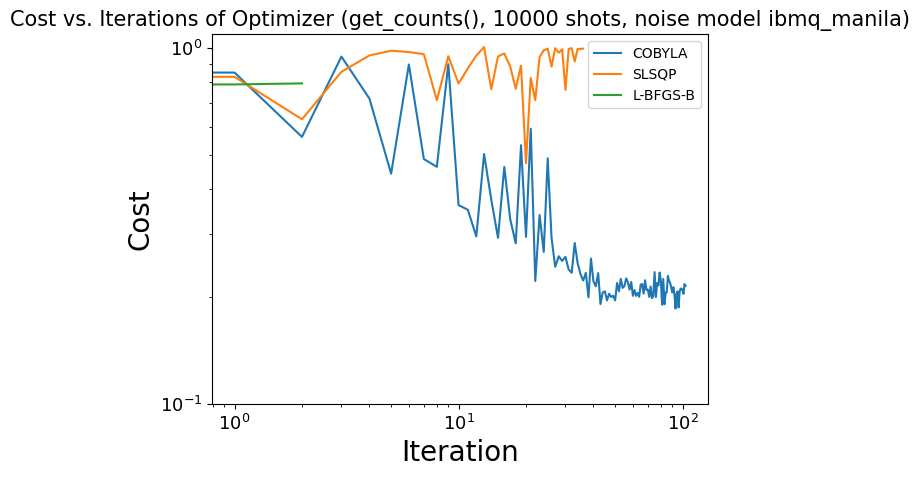

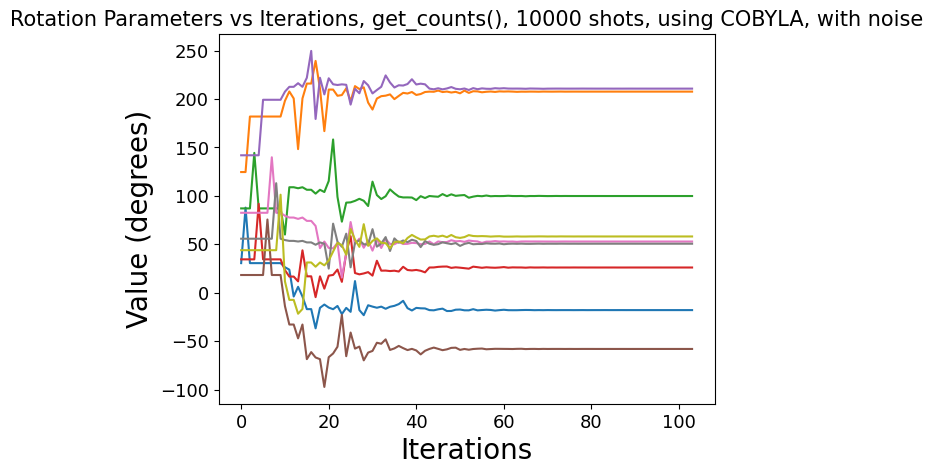

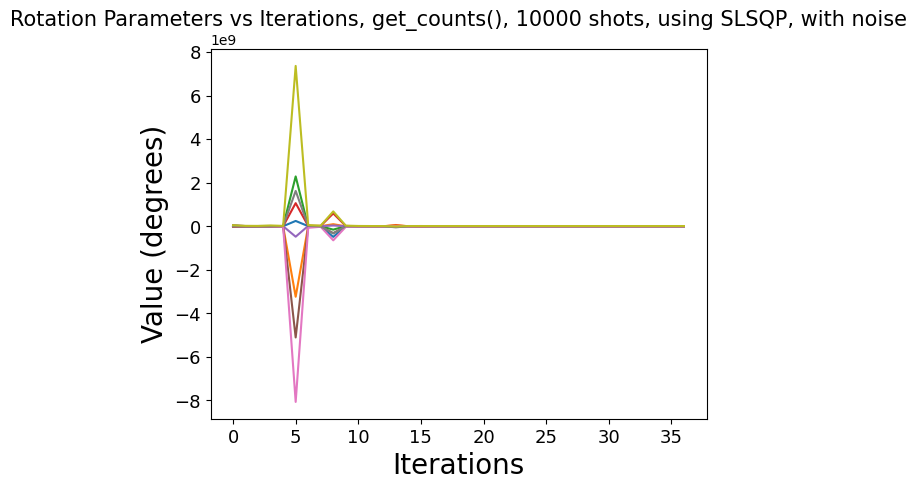

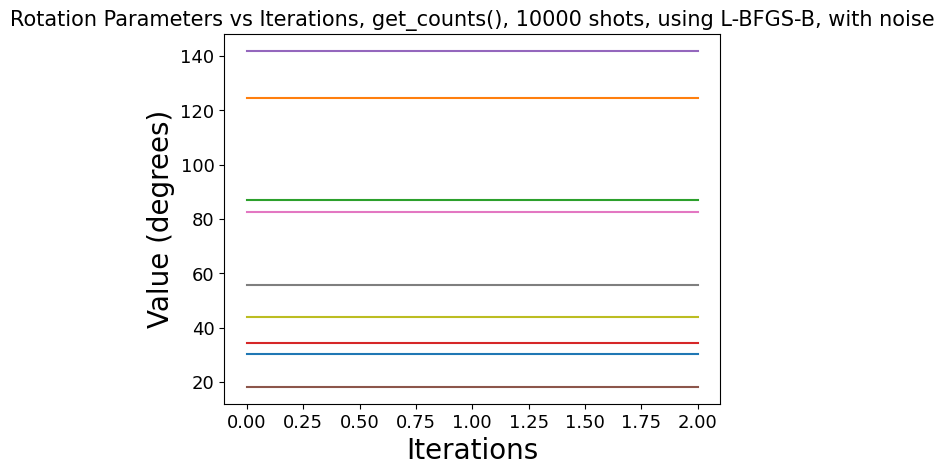

In [ ]:
import matplotlib.pyplot as plt
from math import pi
from functools import reduce


#IND determines whether to print each graph individually
IND = False

for i in range(len(optimizers)):
    cost_plot = reduce(lambda a,h: a + [h] if not h == 0 else a, cost_sum[i], [])
    plt.loglog(cost_plot)
    if IND: 
        plt.ylim(math.pow(10,-6))
        plt.legend([optimizers[i]])
        plt.show()


plt.xlabel('Iteration',fontsize=20)
plt.ylabel('Cost',fontsize=20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(math.pow(10,-1))
plt.legend(optimizers)
title = "Cost vs. Iterations of Optimizer (get_counts(), " + str(SHOTS) +" shots, " + ("noise model ibmq_manila)" if NOISE else "no noise)" )
plt.title(title, fontsize=15)
plt.savefig(title +".pdf", bbox_inches='tight')
# Seed:
print("Starting  with k = : " + str(k))
plt.show()

for j in range(len(optimizers)):
    for i in range(len(all_params[0][0])):
        plt.plot(list(map(lambda h: (180/pi)*h[i], all_params[j])))

    plt.xlabel("Iterations", fontsize=20)
    plt.ylabel("Value (degrees)", fontsize=20)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    title = "Rotation Parameters vs Iterations, get_counts(), " + str(SHOTS) + " shots, using " + optimizers[j] + (", with noise" if NOISE else ", without noise")
    plt.title(title, fontsize=15)
    plt.savefig(title + ".pdf", bbox_inches='tight')
    plt.show()


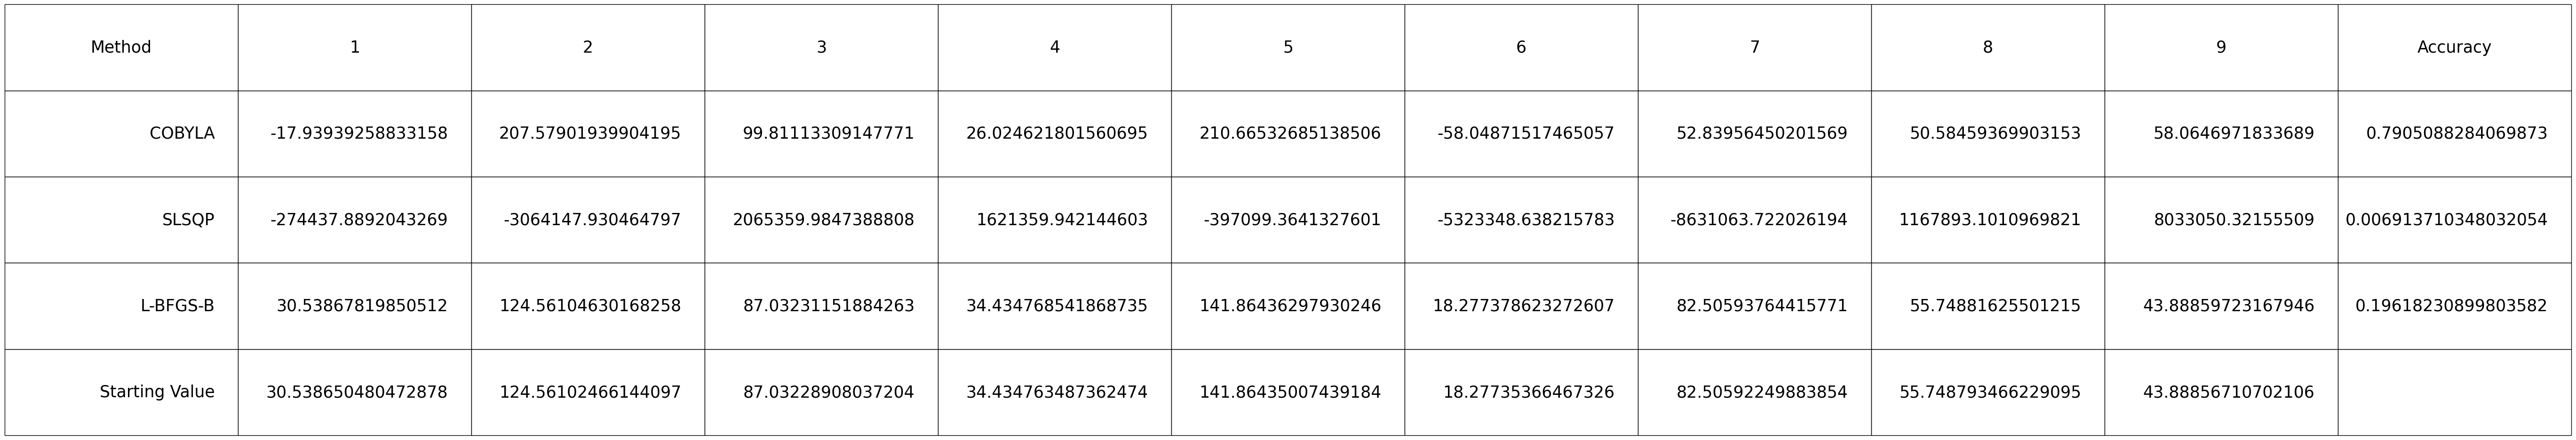

In [ ]:
import pandas as pd

all_params_table = []

cols = ["Method"]
cols += [str(x+1) for x in range(9)]
cols += ["Accuracy"]

for j in range(len(optimizers)):
    next_row = []
    next_row += [optimizers[j]]
    for e in all_params[j][len(all_params[j])-1]:
        next_row += [e*(180/pi)]
    next_row += [(accuracy[j]).real]
    all_params_table += [next_row]

next_row = ["Starting Value"]
next_row += list(map(lambda h: h*(180/pi), k))
next_row += [""]
all_params_table += [next_row]

fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')

df = pd.DataFrame(all_params_table, columns=cols)

table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(25)
table.scale(11,11)
plt.savefig("Final Parameters and Accuracy, get_counts(), per Optimization method" + (" (with noise)" if NOISE else " (without noise)") +".pdf", bbox_inches='tight')
plt.show()